Epoch 1/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 10s 923us/step - accuracy: 0.4992 - loss: 0.3818
Epoch 2/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 9s 928us/step - accuracy: 0.5003 - loss: 0.3467
Epoch 3/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 9s 922us/step - accuracy: 0.5006 - loss: 0.3469
Epoch 4/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 9s 962us/step - accuracy: 0.5011 - loss: 0.3467
Epoch 5/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.5015 - loss: 0.3468
Epoch 6/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.5006 - loss: 0.3465
Epoch 7/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.4996 - loss: 0.3470
Epoch 8/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.5002 - loss: 0.3464
Epoch 9/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.4998 - loss: 0.3471
Epoch 10/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.5007 - loss: 0.3479
Epoch 11/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.5000 - loss: 0.3463
Epoch 12/50
94

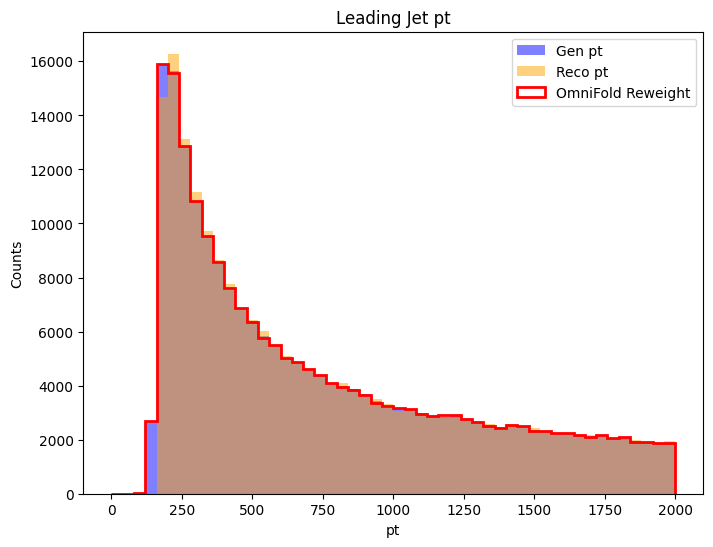

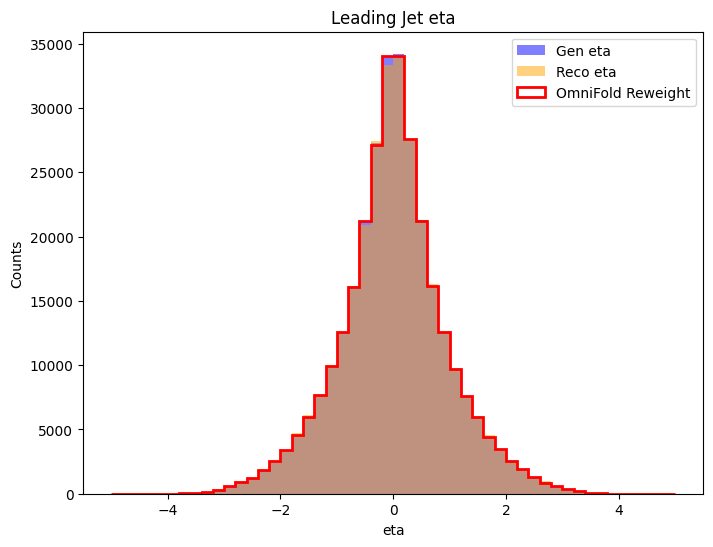

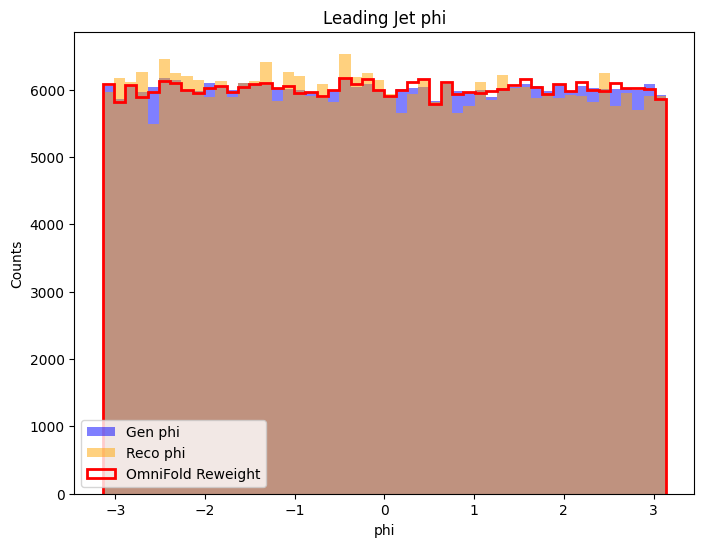

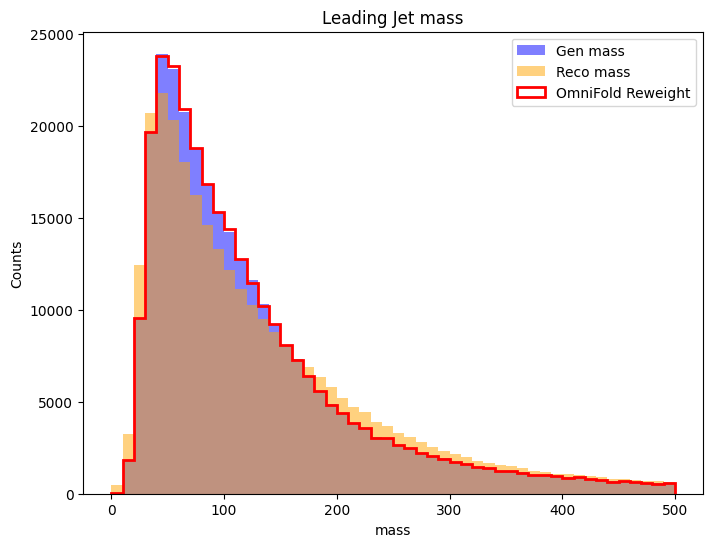

In [2]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the binary crossentropy 
def binary_crossentropy_from_logits(y_true, y_pred):
    return tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, labels=y_true, pos_weight=1))

# Define the model architecture and compilation
def build_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.1),
        Dense(128, activation='relu'),
        Dropout(0.1),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss=binary_crossentropy_from_logits, metrics=['accuracy'])
    return model

# Define the OmniFold method
def omnifold(theta0, theta_unknown_S, iterations, model, verbose):
    labels = np.random.randint(0, 2, size=(len(theta0), 1))  # Binary labels
    weights = np.random.rand(len(theta0))  # Sample weights
    model.fit(theta0, labels, sample_weight=weights, epochs=50, verbose=verbose)
    return np.random.rand(len(theta0))

# Load data from ROOT file
qcd_mc = uproot.open('Data2.root')['Events']

# Extract reco and gen jet data
fields = ['pt', 'eta', 'phi', 'mass']
jet_reco = {f: qcd_mc[f'FatJet_{f}'].array()[:, :1] for f in fields}
jet_gen = {f: qcd_mc[f'GenJetAK8_{f}'].array()[:, :1] for f in fields}

# Mask to filter valid events
mask = (ak.num(jet_reco['pt'], axis=1) > 0) & (ak.num(jet_gen['pt'], axis=1) > 0)
for f in fields:
    jet_reco[f] = jet_reco[f][mask]
    jet_gen[f] = jet_gen[f][mask]

# Prepare data for OmniFold reweighting
theta0 = np.stack([ak.to_numpy(jet_gen['pt']), ak.to_numpy(jet_gen['eta'])], axis=1)
theta_unknown_S = np.stack([ak.to_numpy(jet_reco['pt']), ak.to_numpy(jet_reco['eta'])], axis=1)

# Initialize and compile the model for OmniFold
input_dim = theta0.shape[1]
model = build_model(input_dim)

# Run OmniFold and obtain the weights
weights = omnifold(theta0, theta_unknown_S, iterations=30, model=model, verbose=1)

# Normalize the weights
normalized_weights = weights / np.sum(weights) * len(weights)


# Calculate DeltaR
delta_eta = ak.to_numpy(jet_reco['eta'] - jet_gen['eta'])
delta_phi = ak.to_numpy((jet_reco['phi'] - jet_gen['phi'] + np.pi) % (2 * np.pi) - np.pi)
delta_r = np.sqrt(delta_eta**2 + delta_phi**2)


# Define bins for histograms
bin_settings = {
    'pt': np.linspace(0, 2000, 51),
    'eta': np.linspace(-5, 5, 51),
    'phi': np.linspace(-np.pi, np.pi, 51),
    'mass': np.linspace(0, 500, 51),
}

# Plotting histograms individually
for prop in fields:
    plt.figure(figsize=(8, 6))
    bins = bin_settings[prop]
    gen_data = ak.to_numpy(ak.flatten(jet_gen[prop]))
    reco_data = ak.to_numpy(ak.flatten(jet_reco[prop]))
    plt.hist(gen_data, bins=bins, alpha=0.5, label=f'Gen {prop}', color='blue')
    plt.hist(reco_data, bins=bins, alpha=0.5, label=f'Reco {prop}', color='orange')
    plt.hist(gen_data, bins=bins, weights=normalized_weights, histtype='step', label='OmniFold Reweight', color='red', linewidth=2)
    plt.title(f'Leading Jet {prop}')
    plt.xlabel(prop)
    plt.ylabel('Counts')
    plt.legend()
    plt.show()

    
